In [1]:
#Utility
import numpy as np
import pandas as pd

import glob
import time
import os
from math import sqrt
import warnings

#kera for tensorflow support
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

#Data Visuallization
import matplotlib.pyplot as plt

## Datasource folders

In [2]:
YAHOO_DS="/root/WS/CS-533/TERM-PROJECT/Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0"
DIRS = ['A1Benchmark', 'A2Benchmark','A3Benchmark', 'A4Benchmark']
DATA_FILE_EXTENSION = "*.csv"
warnings.filterwarnings('ignore')

In [3]:
Benchmark_dir  = YAHOO_DS + os.path.sep + DIRS[1] + os.path.sep 
Benchmark_dir

'/root/WS/CS-533/TERM-PROJECT/Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/'

## Reading Data

In [4]:
def standardize_array(values_to_standardize):
    scaler2 = StandardScaler()
    scaler2 = scaler2.fit(values_to_standardize)
    standardaized = scaler2.transform(values_to_standardize)
    return standardaized

In [5]:
def read_data_set(file_name_to_read):
    dataset = pd.read_csv(file_name_to_read, usecols=[1, 2])
    dataset = dataset.values
    dataset = dataset.astype('float32')
    standardize_val = standardize_array(dataset[:, [0]])
    dataset[:, [0]] = standardize_val
    return dataset

In [6]:
def split_data_set(dataset, split=0.67):
    train_size = int(len(dataset) * split)
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    return train, test

In [7]:
def look_back_and_create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i + 1, 0]
        dataX.append(a)
        dataY.append(dataset[i, 1])
    #print('Length of input ', len(dataset), '\nShape of input  ', dataset.shape, '\nShape of dataX ', dataX.shape, '\nShape of dataY ', dataY.shape)
    return np.array(dataX), np.array(dataY)

In [8]:
#A1 = glob.glob(f'../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/**/*.csv', recursive=True)
A1 = glob.glob(Benchmark_dir + DATA_FILE_EXTENSION, recursive=True)
#A1

In [9]:
def get_train_test_data_from_file(file_name, partition_size = .8, look_back=20):
    print('File Name : ', file_name)
    data_read_from_file = read_data_set(file_name)
    train, test = split_data_set(data_read_from_file, partition_size)
    Xtrain, Ytrain = look_back_and_create_dataset(train, look_back)
    Xtest, Ytest = look_back_and_create_dataset(test, look_back)
    return data_read_from_file, Xtrain, Ytrain, Xtest, Ytest   

In [10]:
partition_size = .8,
look_back=20
start_millis = int(round(time.time() * 1000))
num_files = 0
for data_file in A1:
    all_data, Xtrain, Ytrain, Xtest, Ytest = get_train_test_data_from_file(data_file)
    print('Shape of Xtrain ', Xtrain.shape, 'Shape of Ytrain ', Ytrain.shape)
    print('Shape of XTest  ', Xtest.shape,  'Shape of Ytest ', Ytest.shape)
    #This needs to be removed once, all files are being processed.
    num_files +=1
    if num_files == 1 :
        break
end_millis = int(round(time.time() * 1000))
print (f'Loaded {num_files} data files from the location {Benchmark_dir} in {end_millis - start_millis} ms')

File Name :  /root/WS/CS-533/TERM-PROJECT/Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_1.csv
Shape of Xtrain  (1116, 21) Shape of Ytrain  (1116,)
Shape of XTest   (265, 21) Shape of Ytest  (265,)
Loaded 1 data files from the location /root/WS/CS-533/TERM-PROJECT/Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/ in 8 ms


In [11]:
model = Sequential()
model.add(Dense(8, input_dim=look_back+1, activation='relu'))
#model.add(Dense(10,  activation='relu'))
#model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
model.fit(Xtrain, Ytrain, epochs=25, batch_size=1000, verbose=0)

In [13]:
# evaluate the keras model
# Estimate model performance
trainScore = model.evaluate(Xtrain, Ytrain, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, sqrt(trainScore)))
testScore = model.evaluate(Xtest, Ytest, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, sqrt(testScore)))

Train Score: 0.03 MSE (0.18 RMSE)
Test Score: 0.02 MSE (0.13 RMSE)


In [14]:
trainPredict = model.predict(Xtrain)
testPredict = model.predict(Xtest)

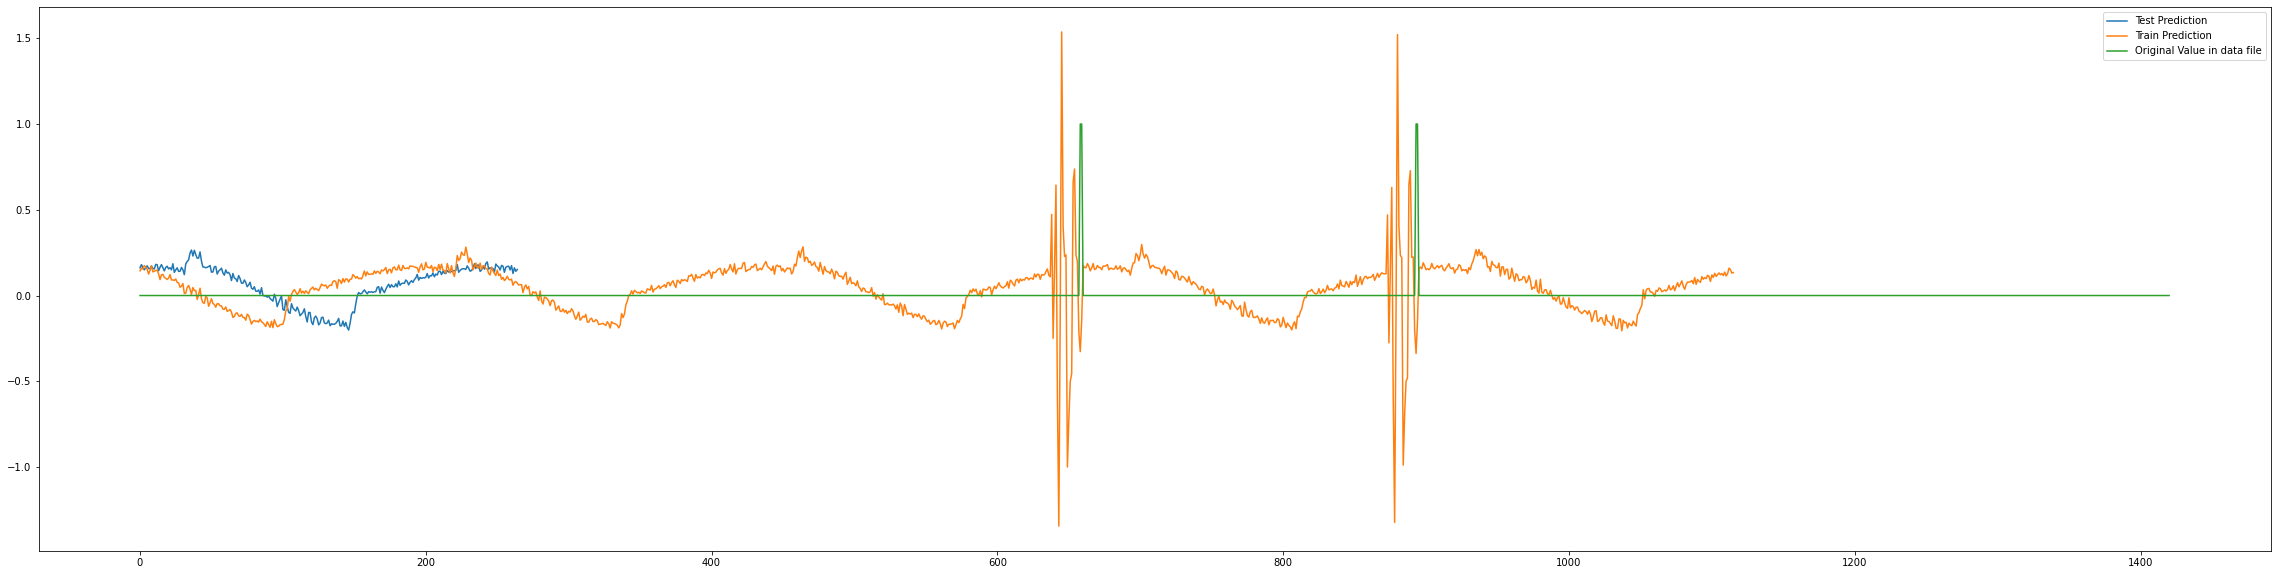

In [15]:
plt.figure(figsize=(40,10))
plt.plot(testPredict, Label ='Test Prediction')
plt.plot(trainPredict, Label ='Train Prediction')
plt.plot(all_data[:,1], Label = 'Original Value in data file')
plt.legend(("Test Prediction", "Train Prediction", "Original Value in data file"))
plt.show()

####  Applying .8 Threshold to classify

In [17]:
trainPredictThreshold = (trainPredict >= .8).astype(int)
testPredictThreshold = (testPredict > .8).astype(int)
print(np.unique(trainPredictThreshold,  return_counts=True))
print(np.unique(testPredictThreshold, return_counts=True))

(array([0, 1]), array([1114,    2]))
(array([0]), array([265]))


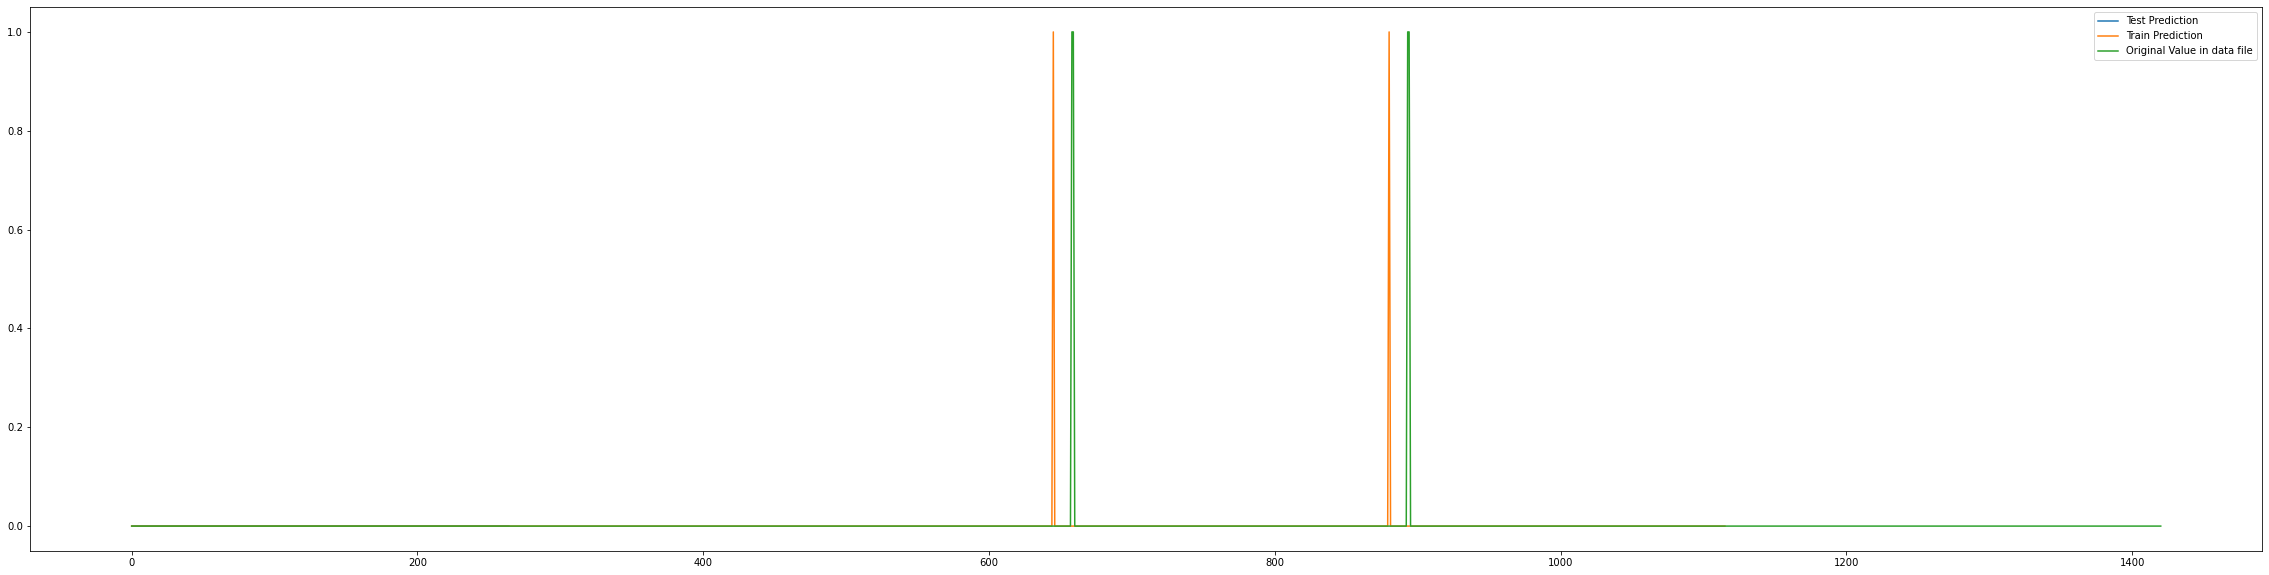

In [18]:
plt.figure(figsize=(40,10))
plt.plot(testPredictThreshold, Label ='Test Prediction')
plt.plot(trainPredictThreshold, Label ='Train Prediction')
plt.plot(all_data[:,1], Label = 'Original Value in data file')
plt.legend(("Test Prediction", "Train Prediction", "Original Value in data file"))
plt.show()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 176       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________
